# Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier # KNN

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
1,2,52,1,3,152,298,1,1,178,0,1.2,1,0,3,1
2,3,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
3,4,45,0,0,138,236,0,0,152,1,0.2,1,0,2,1
4,5,35,1,1,122,192,0,1,174,0,0.0,2,0,2,1


In [4]:
test.head()

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,1,57,1,0,150,276,0,0,112,1,0.6,1,1,1
1,2,59,1,3,170,288,0,0,159,0,0.2,1,0,3
2,3,57,1,2,150,126,1,1,173,0,0.2,2,1,3
3,4,56,0,0,134,409,0,0,150,1,1.9,1,2,3
4,5,71,0,2,110,265,1,0,130,0,0.0,2,1,2


In [5]:
train.shape, test.shape, submission.shape

((151, 15), (152, 14), (152, 2))

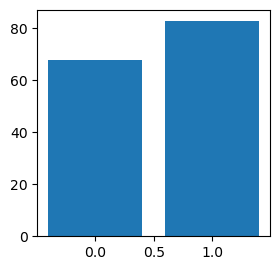

In [6]:
# label의 분포 확인
target_counts = pd.DataFrame(train['target'].value_counts()).reset_index()

plt.figure(figsize = (3,3), dpi = 100)
plt.bar(target_counts['index'], target_counts['target'])
plt.show()

In [7]:
train = train.drop(['id'], axis = 1)
test = test.drop(['id'], axis = 1)

# EDA

In [8]:
feature = list(train.columns)

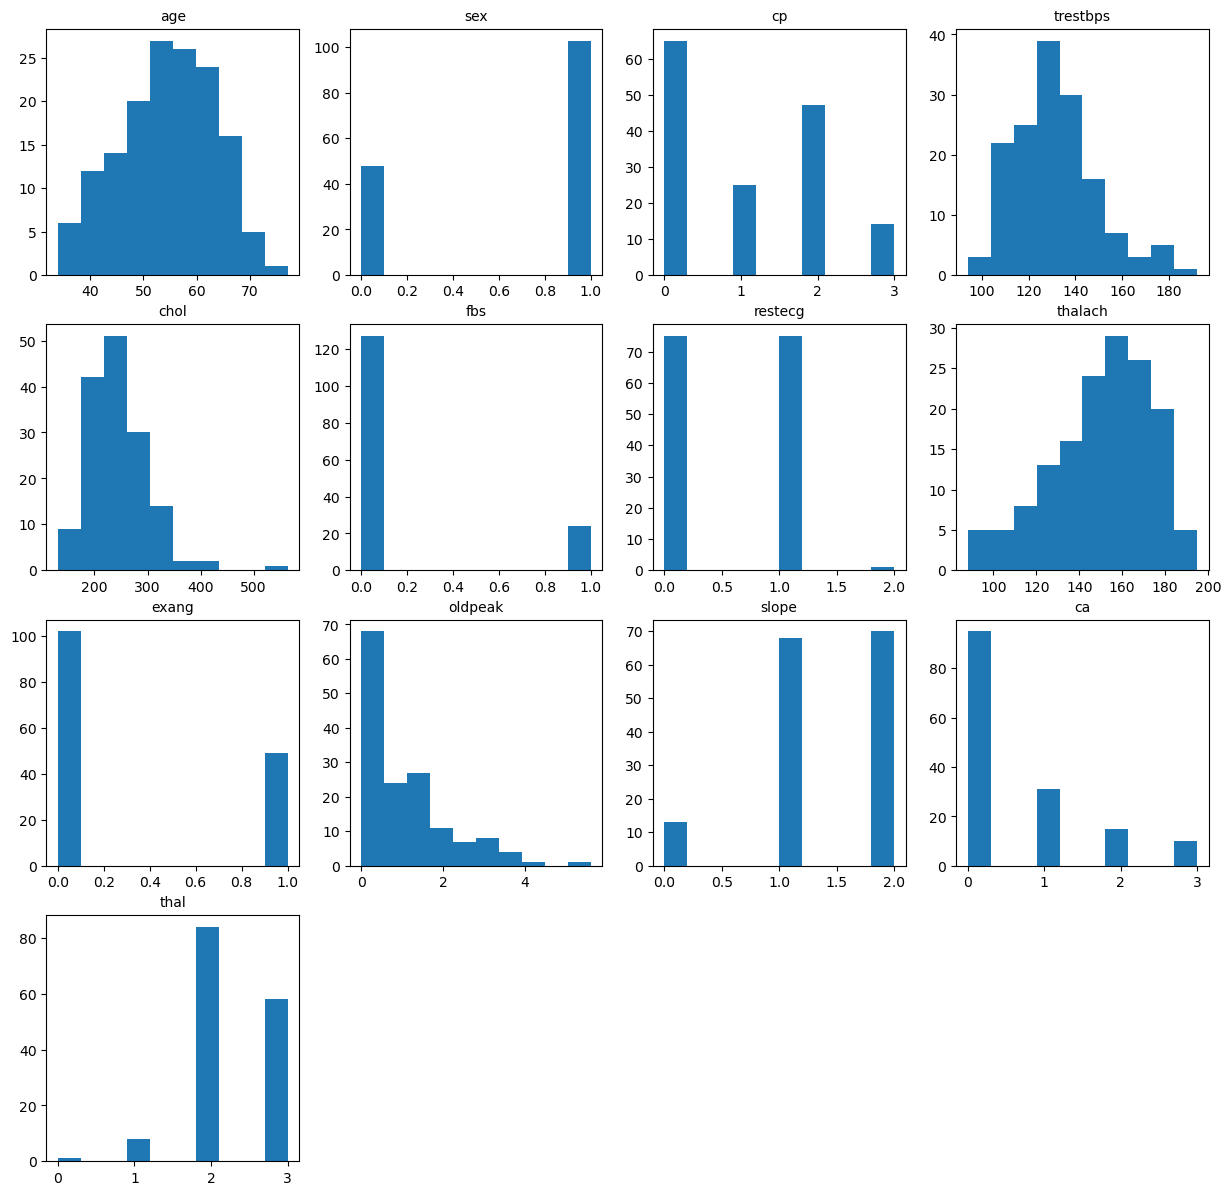

In [9]:
plt.figure(figsize = (15,15), dpi = 100)
for i, col in enumerate(feature[:-1]):
    plt.subplot(4, 4, i+1)
    plt.hist(train[col])
    plt.title(col, fontsize = 10)
plt.show()

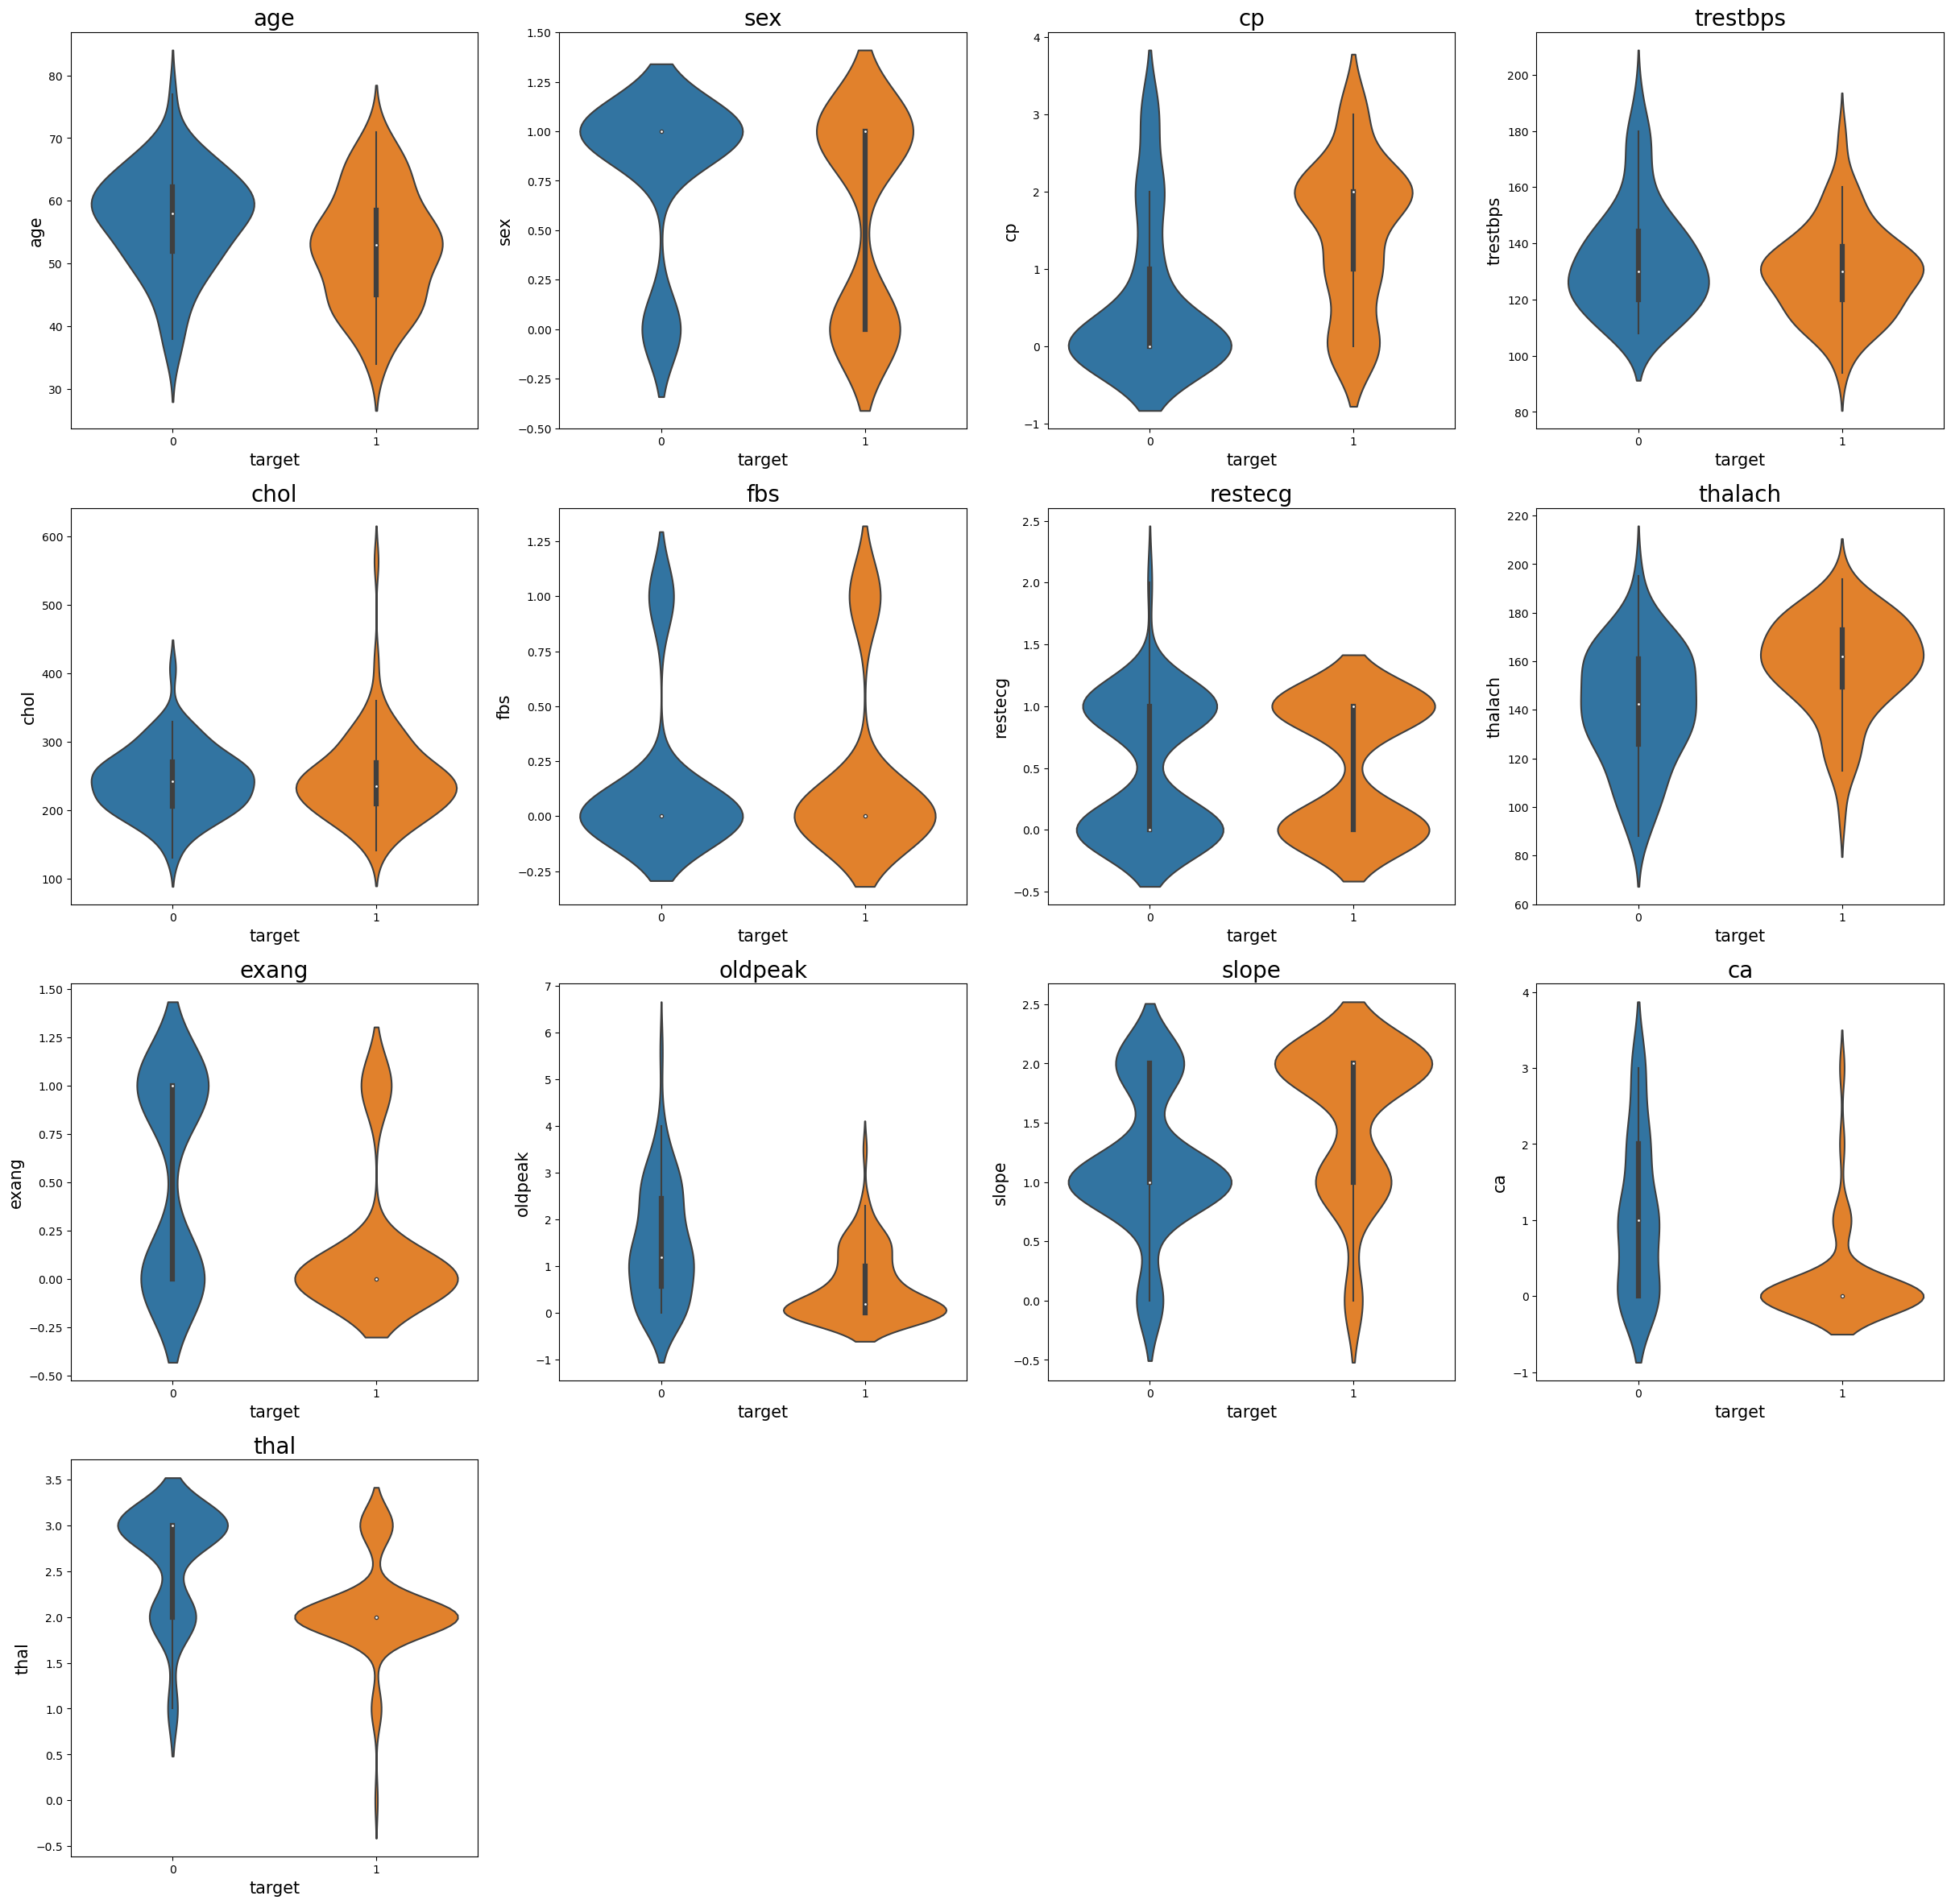

In [10]:
plt.figure(figsize = (30,30), dpi = 100)
for i, col in enumerate(feature[:-1]):
    plt.subplot(4, 4, i+1)
    sns.violinplot(x = train['target'], y = train[col])
    plt.xlabel('target', fontsize = 15)
    plt.ylabel(col, fontsize = 15)
    plt.title(col, fontsize = 20)
plt.show()

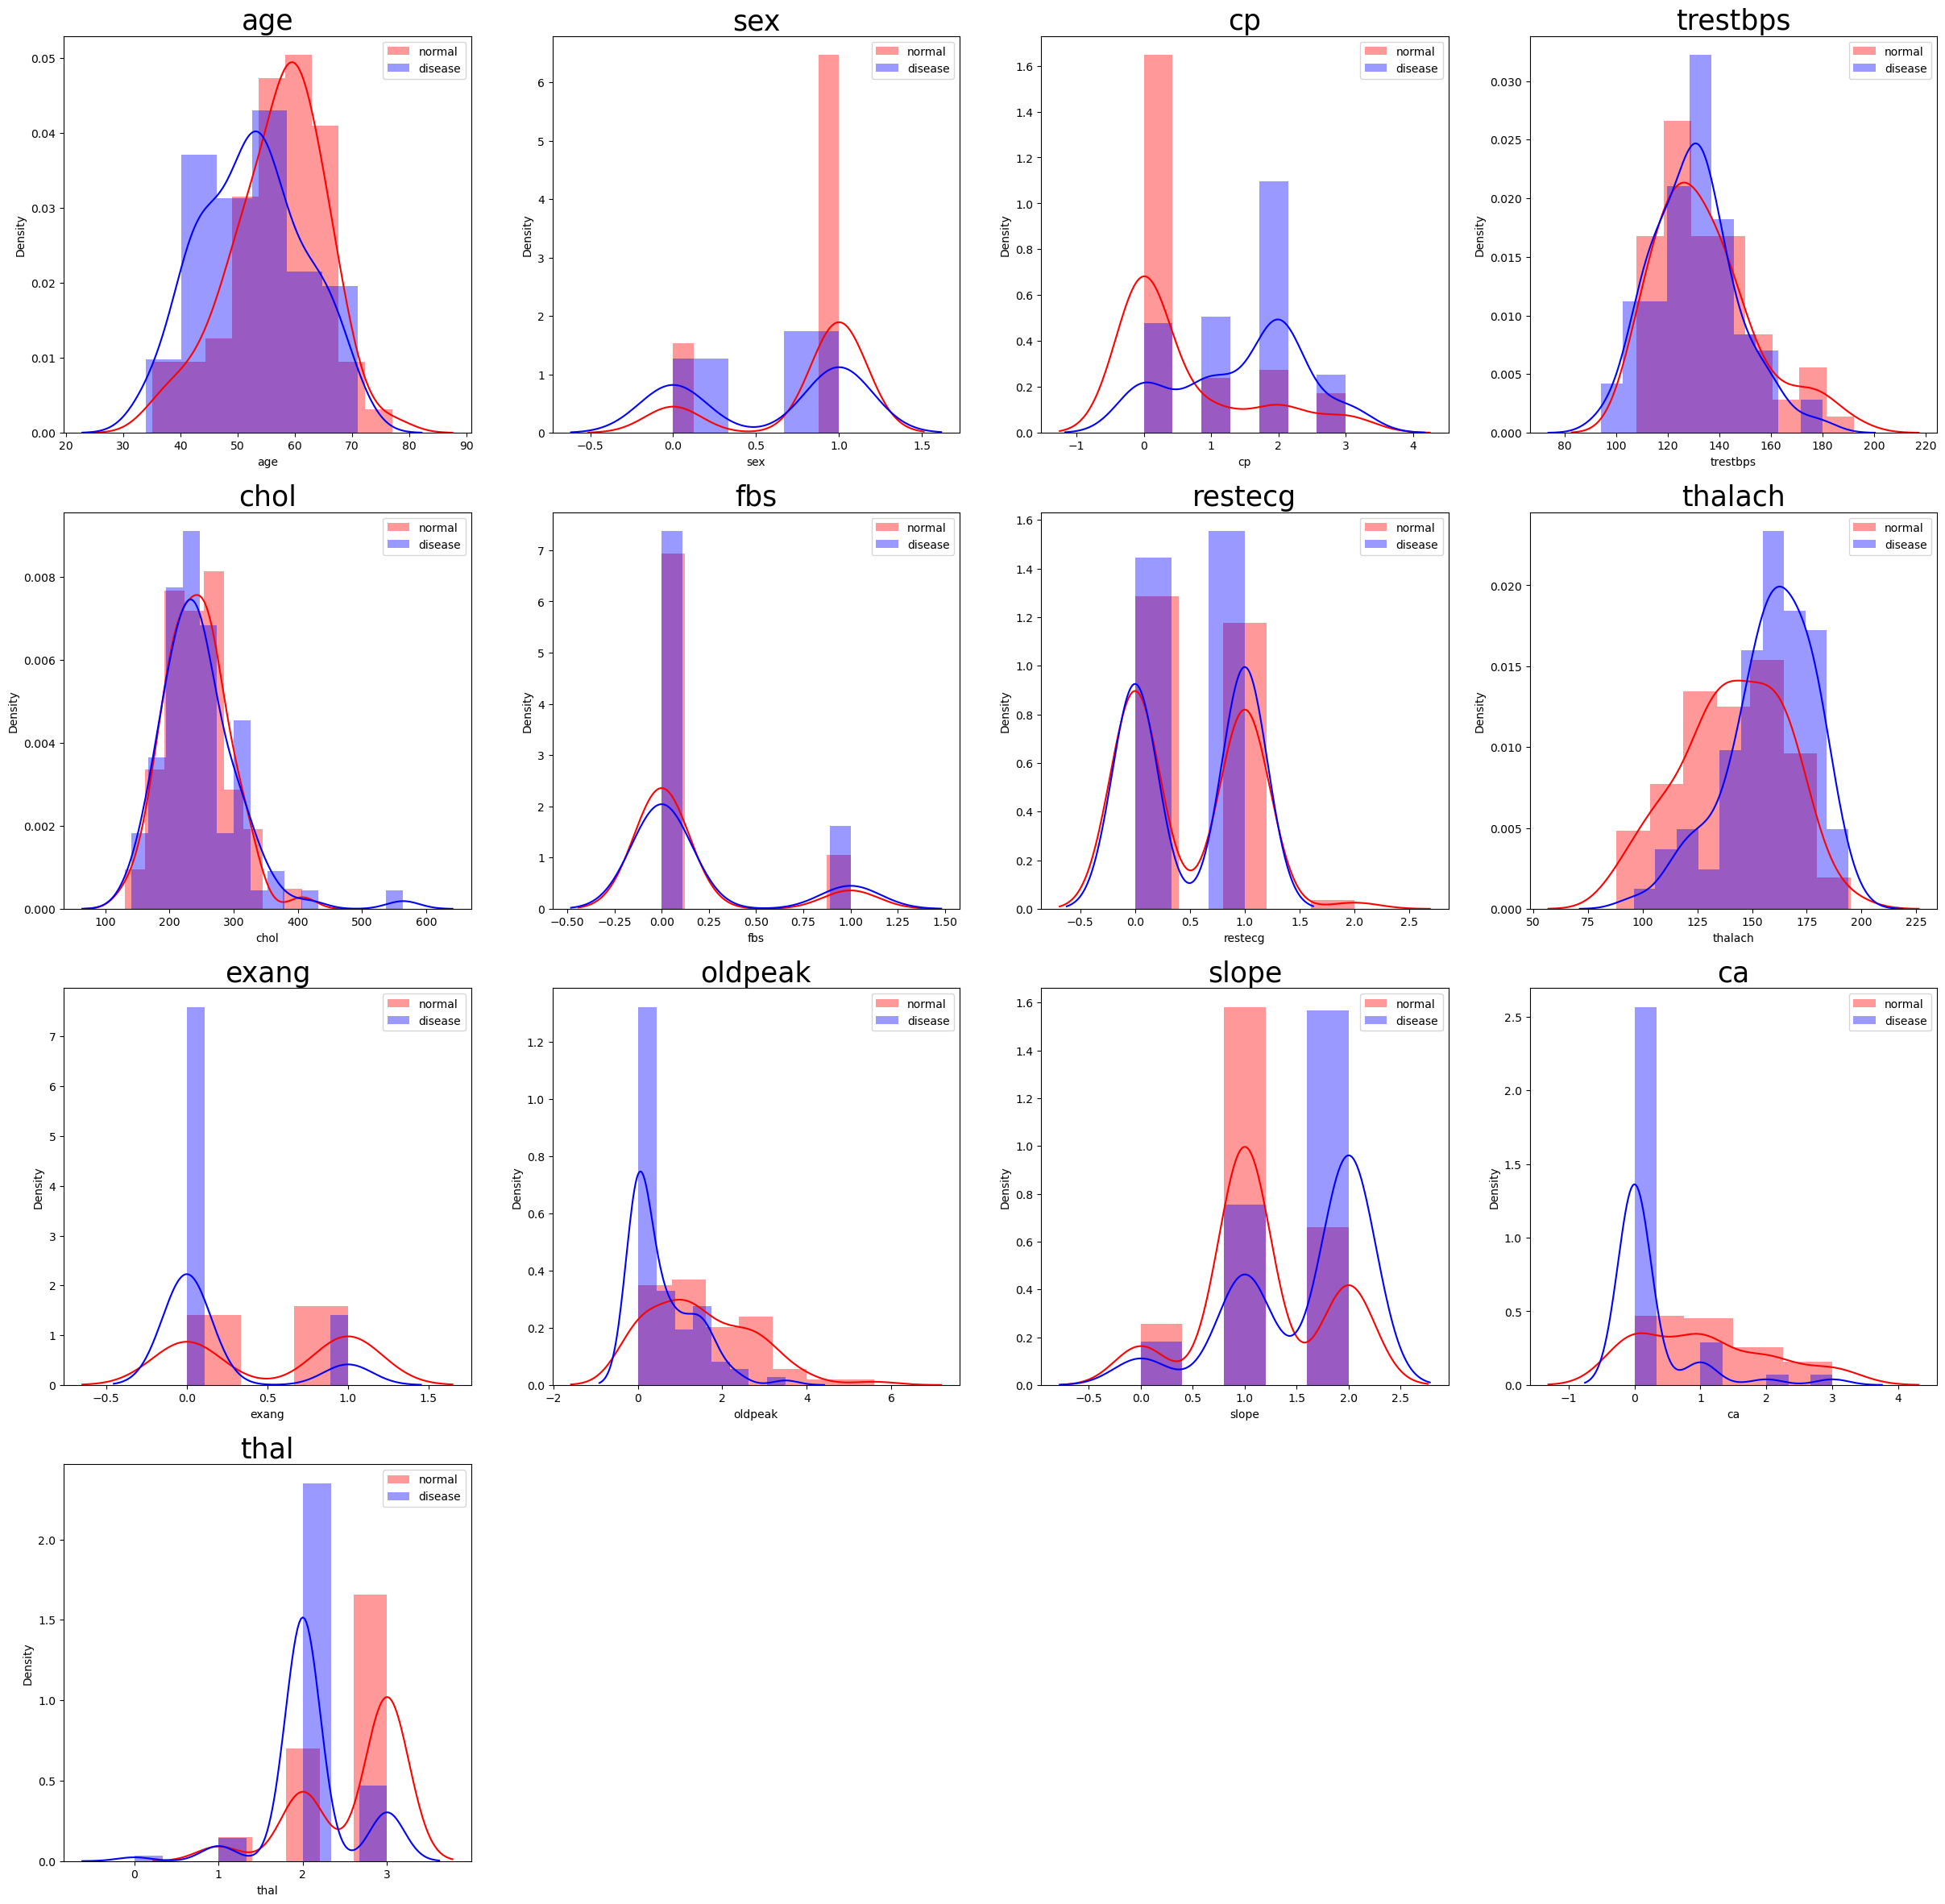

In [11]:
plt.figure(figsize = (30,30), dpi = 100)
for i, col in enumerate(feature[:-1]):
    plt.subplot(4, 4, i+1)
    sns.distplot(train[train['target']==0][col], hist = True, kde=True, color="red", label = 'normal')
    sns.distplot(train[train['target']==1][col], hist = True, kde=True, color="blue", label = 'disease')
    plt.legend()
    plt.title(col, fontsize = 25)
plt.show()

# Preprocessing

In [12]:
train_x = train.drop(['target'], axis = 1)
train_y = train['target']

In [13]:
# age값에서 54.5세보다 크면 1 아니면 0인 열을 추가
train_x['age_binary'] = 0
for i in range(0, len(train_x)):
    if train_x['age'][i] < 54.5:
        train_x['age_binary'][i] = 1
    else:
        train_x['age_binary'][i] = 0

# cp열에 대한 새로운 특징 생성
# 무증상과 유증상에 따라 분류
train_x['pain_exist'] = 0
for i in range(0, len(train_x)):
    if train_x['cp'][i] >= 1:
        train_x['pain_exist'][i] = 1
    else:
        train_x['pain_exist'][i] = 0

# trestbps 열에서 특정 구간에서 target에 차이가 있으므로 이를 새로운 특징으로 추가
train_x['trestbps_category'] = 0
for i in range(0, len(train_x)):
    if (train_x['trestbps'][i] >= 120) and (train_x['trestbps'][i] <= 143):
        train_x['trestbps_category'][i] = 1
    elif train_x['trestbps'][i] >= 160:
        train_x['trestbps_category'][i] = 2
    else:
        train_x['trestbps_category'][i] = 0

# chol값이 330보다 큰 경우 target값 1의 비중이 크므로 이를 따로 분리
train_x['chol_330'] = 0
for i in range(0, len(train_x)):
    if train_x['chol'][i] >= 330:
        train_x['chol_330'][i] = 1
    else:
        train_x['chol_330'][i] = 0

# thalach 값이 147보다 클 때 발병률이 더 크므로 이를 새로운 특징으로 추가
train_x['thalach_binary'] = 0
for i in range(0, len(train_x)):
    if train_x['thalach'][i] >= 147:
        train_x['thalach_binary'][i] = 1
    else:
        train_x['thalach_binary'][i] = 0       

# 협압과 콜레스트롤, 최대심박수를 더한 특징 생성
train_x['tr_ch'] = train_x['trestbps'] + train_x['chol'] + train_x['thalach']

# restecg열에 대한 새로운 특징 생성
# 정상과 비정상으로 나눔
train_x['restecg_binary'] = 0
for i in range(0, len(train_x)):
    if train_x['restecg'][i] == 0 or train_x['restecg'][i] == 2:
        train_x['restecg_binary'][i] = 1
    else:
        train_x['restecg_binary'][i] = 0

# exang 값을 발병률에 따라 다시 매핑
train_x['exang']
for i in range(0, len(train_x)):
    if train_x['exang'][i] == 0:
        train_x['exang'][i] = 1
    else:
        train_x['exang'][i] = 0

# oldpeak의 경우 0.7보다 작은 값에서 발병이 더 많으므로 이를 분리
train_x['oldpeak_binary'] = 0
for i in range(0, len(train_x)):
    if train_x['oldpeak'][i] <= 0.7:
        train_x['oldpeak_binary'][i] = 1
    else:
        train_x['oldpeak_binary'][i] = 0

# slope열에 대한 새로운 특징 생성
# 상승 여부에 따라
train_x['slope_up'] = 0
for i in range(0, len(train_x)):
    if train_x['slope'][i] == 2:
        train_x['slope_up'][i] = 1
    else:
        train_x['slope_up'][i] = 0

# ca열에 대한 새로운 특징 생성
# ca가 0이면 1, 아니면 0
train_x['ca_zero'] = 0
for i in range(0, len(train_x)):
    if train_x['ca'][i] == 0:
        train_x['ca_zero'][i] = 1
    else:
        train_x['ca_zero'][i] = 0
    
# thal에 대한 새로운 특징 생성
# thal 값이 2이면 1, 아니면 0
train_x['thal_two'] = 0
for i in range(0, len(train_x)):
    if train_x['thal'][i] == 2:
        train_x['thal_two'][i] = 1
    else:
        train_x['thal_two'][i] = 0        

In [14]:
# test set에 대해서도 동일한 과정 적용

# age값에서 54.5세보다 크면 1 아니면 0인 열을 추가
test['age_binary'] = 0
for i in range(0, len(test)):
    if test['age'][i] < 54.5:
        test['age_binary'][i] = 1
    else:
        test['age_binary'][i] = 0

# cp열에 대한 새로운 특징 생성
# 무증상과 유증상에 따라 분류
test['pain_exist'] = 0
for i in range(0, len(test)):
    if test['cp'][i] >= 1:
        test['pain_exist'][i] = 1
    else:
        test['pain_exist'][i] = 0

# trestbps 열에서 특정 구간에서 target에 차이가 있으므로 이를 새로운 특징으로 추가
test['trestbps_category'] = 0
for i in range(0, len(test)):
    if (test['trestbps'][i] >= 120) and (test['trestbps'][i] <= 143):
        test['trestbps_category'][i] = 1
    elif test['trestbps'][i] >= 160:
        test['trestbps_category'][i] = 2
    else:
        test['trestbps_category'][i] = 0

# chol값이 330보다 큰 경우 target값 1의 비중이 크므로 이를 따로 분리
test['chol_330'] = 0
for i in range(0, len(test)):
    if test['chol'][i] >= 330:
        test['chol_330'][i] = 1
    else:
        test['chol_330'][i] = 0

# thalach 값이 147보다 클 때 발병률이 더 크므로 이를 새로운 특징으로 추가
test['thalach_binary'] = 0
for i in range(0, len(test)):
    if test['thalach'][i] >= 147:
        test['thalach_binary'][i] = 1
    else:
        test['thalach_binary'][i] = 0       

# 협압과 콜레스트롤, 최대심박수를 더한 특징 생성
test['tr_ch'] = test['trestbps'] + test['chol'] + test['thalach']

# restecg열에 대한 새로운 특징 생성
# 정상과 비정상으로 나눔
test['restecg_binary'] = 0
for i in range(0, len(test)):
    if test['restecg'][i] == 0 or test['restecg'][i] == 2:
        test['restecg_binary'][i] = 1
    else:
        test['restecg_binary'][i] = 0

# exang 값을 발병률에 따라 다시 매핑
test['exang']
for i in range(0, len(test)):
    if test['exang'][i] == 0:
        test['exang'][i] = 1
    else:
        test['exang'][i] = 0

# oldpeak의 경우 0.7보다 작은 값에서 발병이 더 많으므로 이를 분리
test['oldpeak_binary'] = 0
for i in range(0, len(test)):
    if test['oldpeak'][i] <= 0.7:
        test['oldpeak_binary'][i] = 1
    else:
        test['oldpeak_binary'][i] = 0

# slope열에 대한 새로운 특징 생성
# 상승 여부에 따라
test['slope_up'] = 0
for i in range(0, len(test)):
    if test['slope'][i] == 2:
        test['slope_up'][i] = 1
    else:
        test['slope_up'][i] = 0

# ca열에 대한 새로운 특징 생성
# ca가 0이면 1, 아니면 0
test['ca_zero'] = 0
for i in range(0, len(test)):
    if test['ca'][i] == 0:
        test['ca_zero'][i] = 1
    else:
        test['ca_zero'][i] = 0
    
# thal에 대한 새로운 특징 생성
# thal 값이 2이면 1, 아니면 0
test['thal_two'] = 0
for i in range(0, len(test)):
    if test['thal'][i] == 2:
        test['thal_two'][i] = 1
    else:
        test['thal_two'][i] = 0

In [15]:
# 수치형 로그변환
train_x['age'] = np.log1p(train_x['age'])
train_x['trestbps'] = np.log1p(train_x['trestbps'])
train_x['chol'] = np.log1p(train_x['chol'])
train_x['thalach'] = np.log1p(train_x['thalach'])
train_x['oldpeak'] = np.log1p(train_x['oldpeak'])

test['age'] = np.log1p(test['age'])
test['trestbps'] = np.log1p(test['trestbps'])
test['chol'] = np.log1p(test['chol'])
test['thalach'] = np.log1p(test['thalach'])
test['oldpeak'] = np.log1p(test['oldpeak'])

In [16]:
train_x['age'] = (-1) * train_x['age']
train_x['oldpeak'] = (-1) * train_x['oldpeak']
train_x['ca'] = (-1) * train_x['ca']
train_x['thal'] = (-1) * train_x['thal']

test['age'] = (-1) * test['age']
test['oldpeak'] = (-1) * test['oldpeak']
test['ca'] = (-1) * test['ca']
test['thal'] = (-1) * test['thal']

In [17]:
train_x['sex'] = train_x['sex'].map({0:1, 1:0})
test['sex'] = test['sex'].map({0:1, 1:0})

In [18]:
train_x.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'age_binary', 'pain_exist',
       'trestbps_category', 'chol_330', 'thalach_binary', 'tr_ch',
       'restecg_binary', 'oldpeak_binary', 'slope_up', 'ca_zero', 'thal_two'],
      dtype='object')

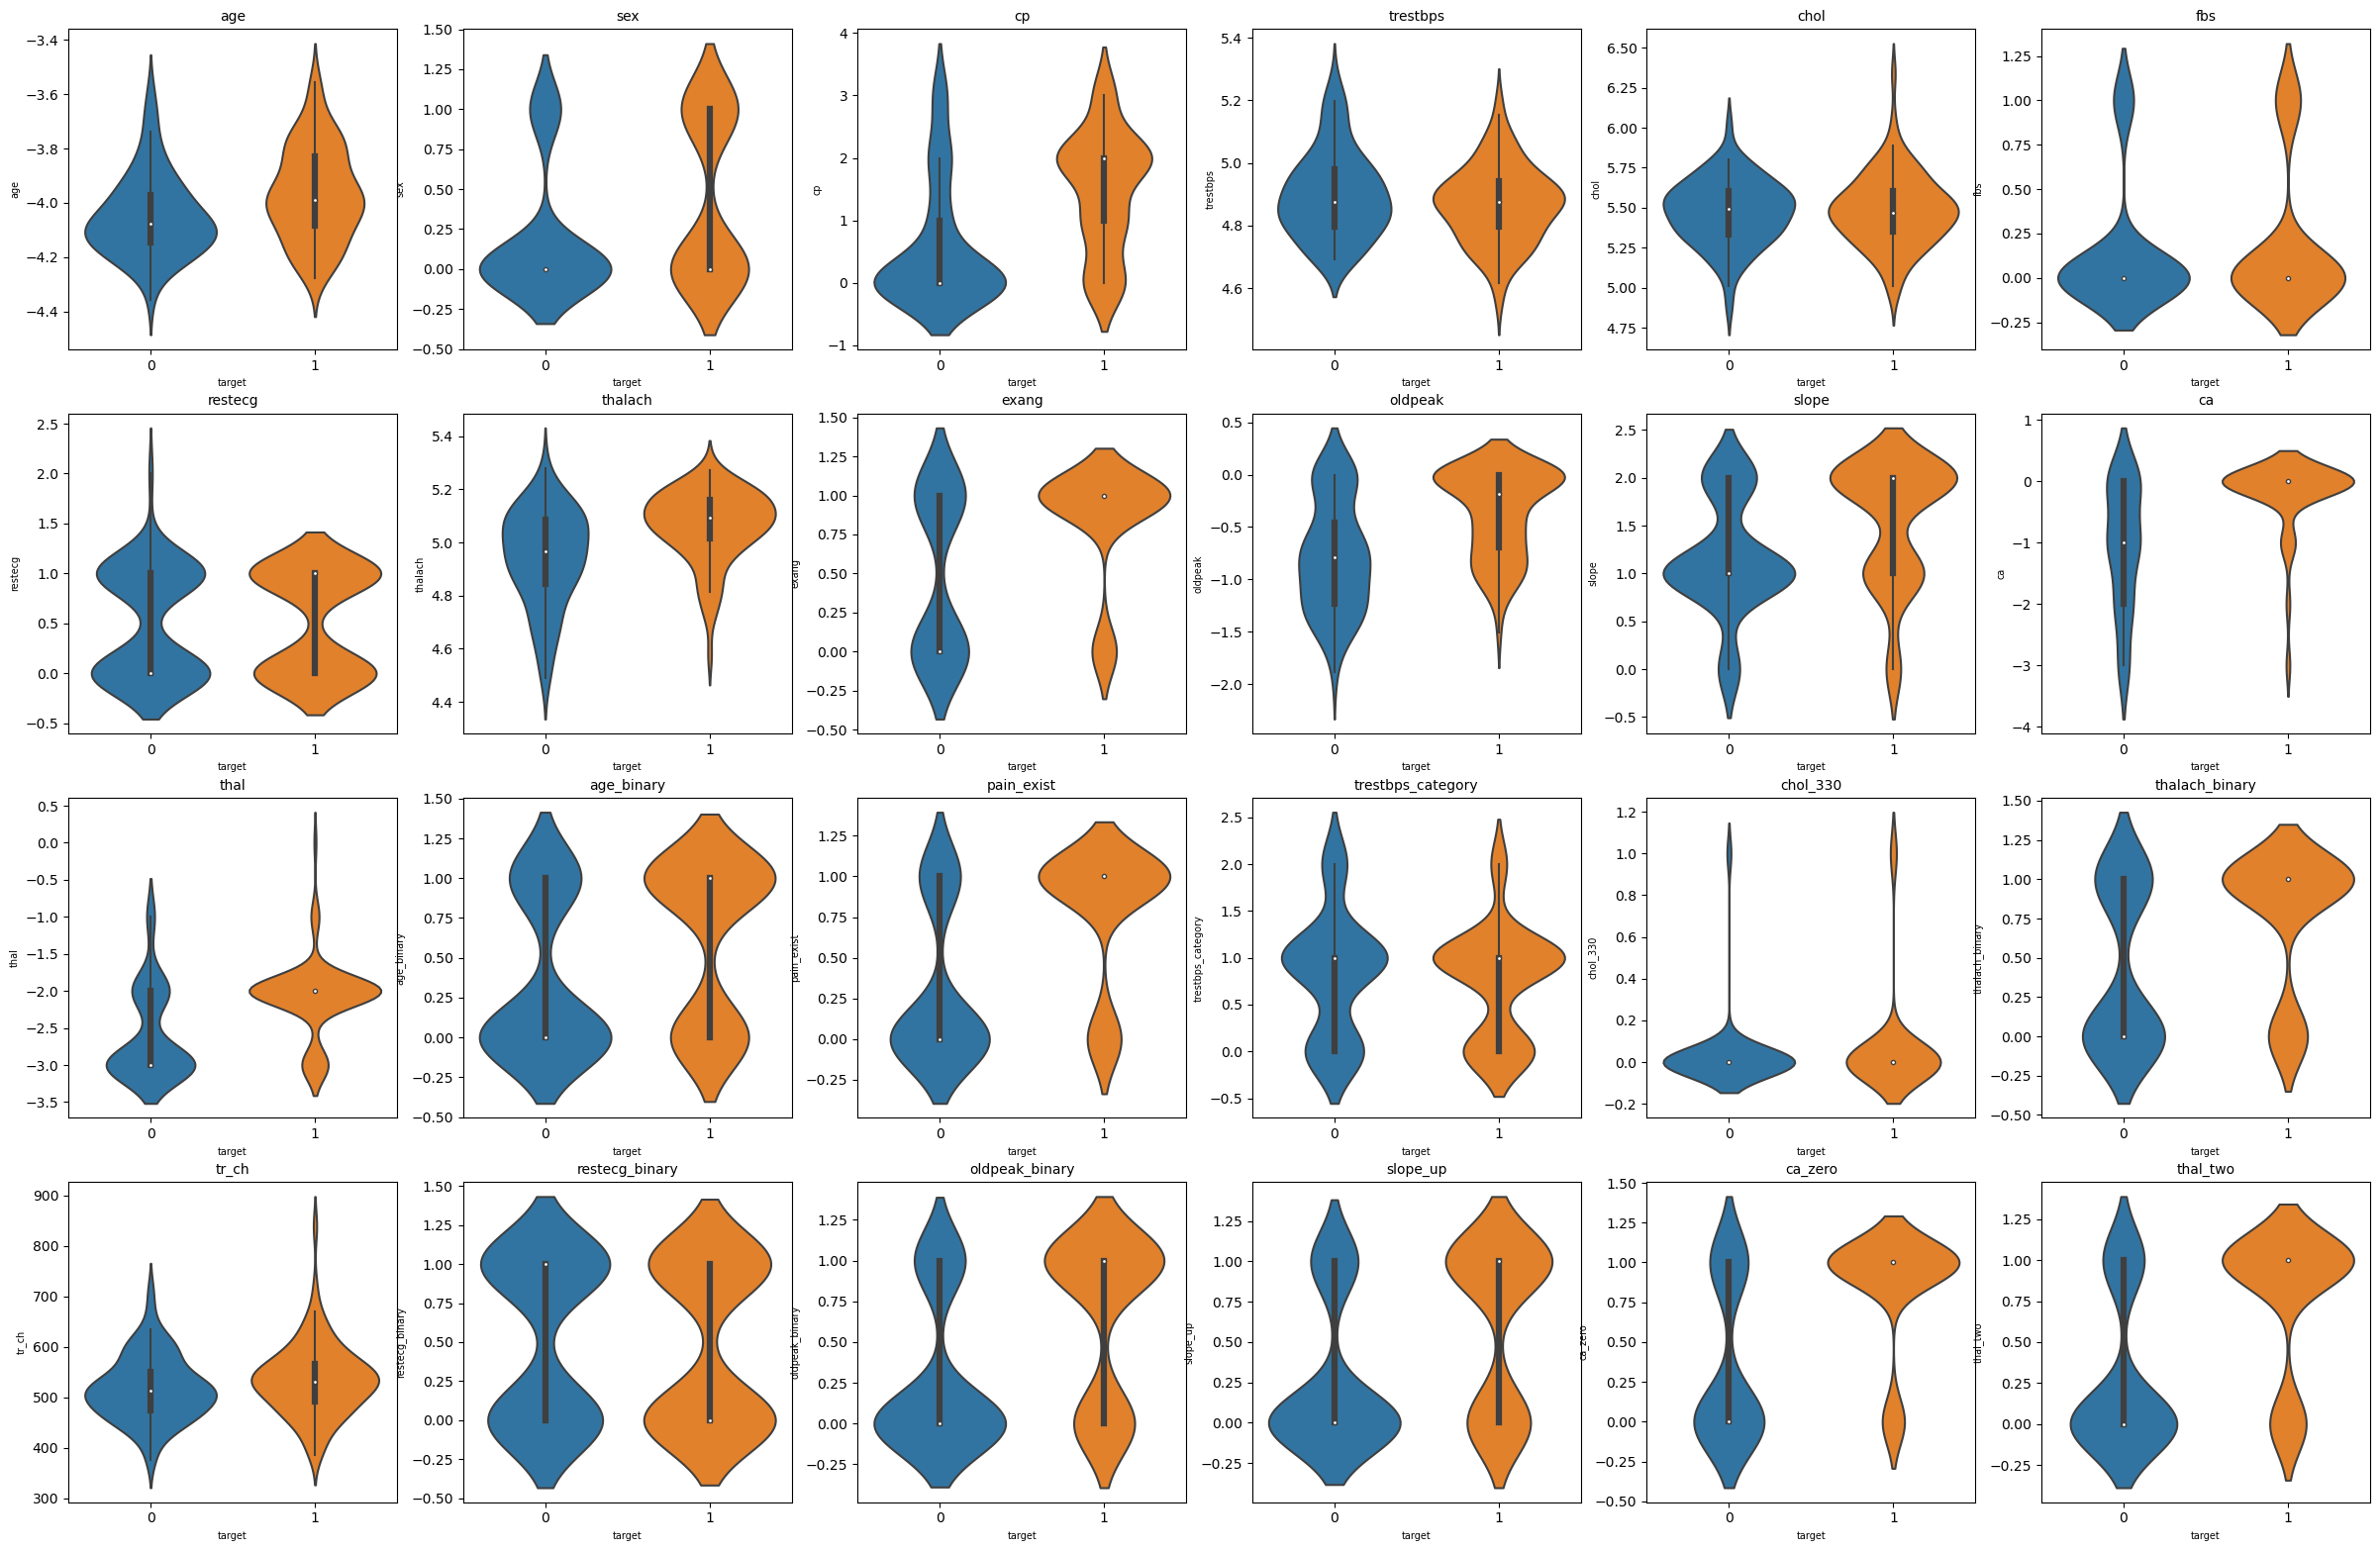

In [21]:
plt.figure(figsize = (30,30), dpi = 100)
for i, col in enumerate(list(train_x.columns)):
    plt.subplot(6, 6, i+1)
    sns.violinplot(x = train_y, y = train_x[col])
    plt.xlabel('target', fontsize = 7)
    plt.ylabel(col, fontsize = 7)
    plt.title(col, fontsize = 10)
plt.show()

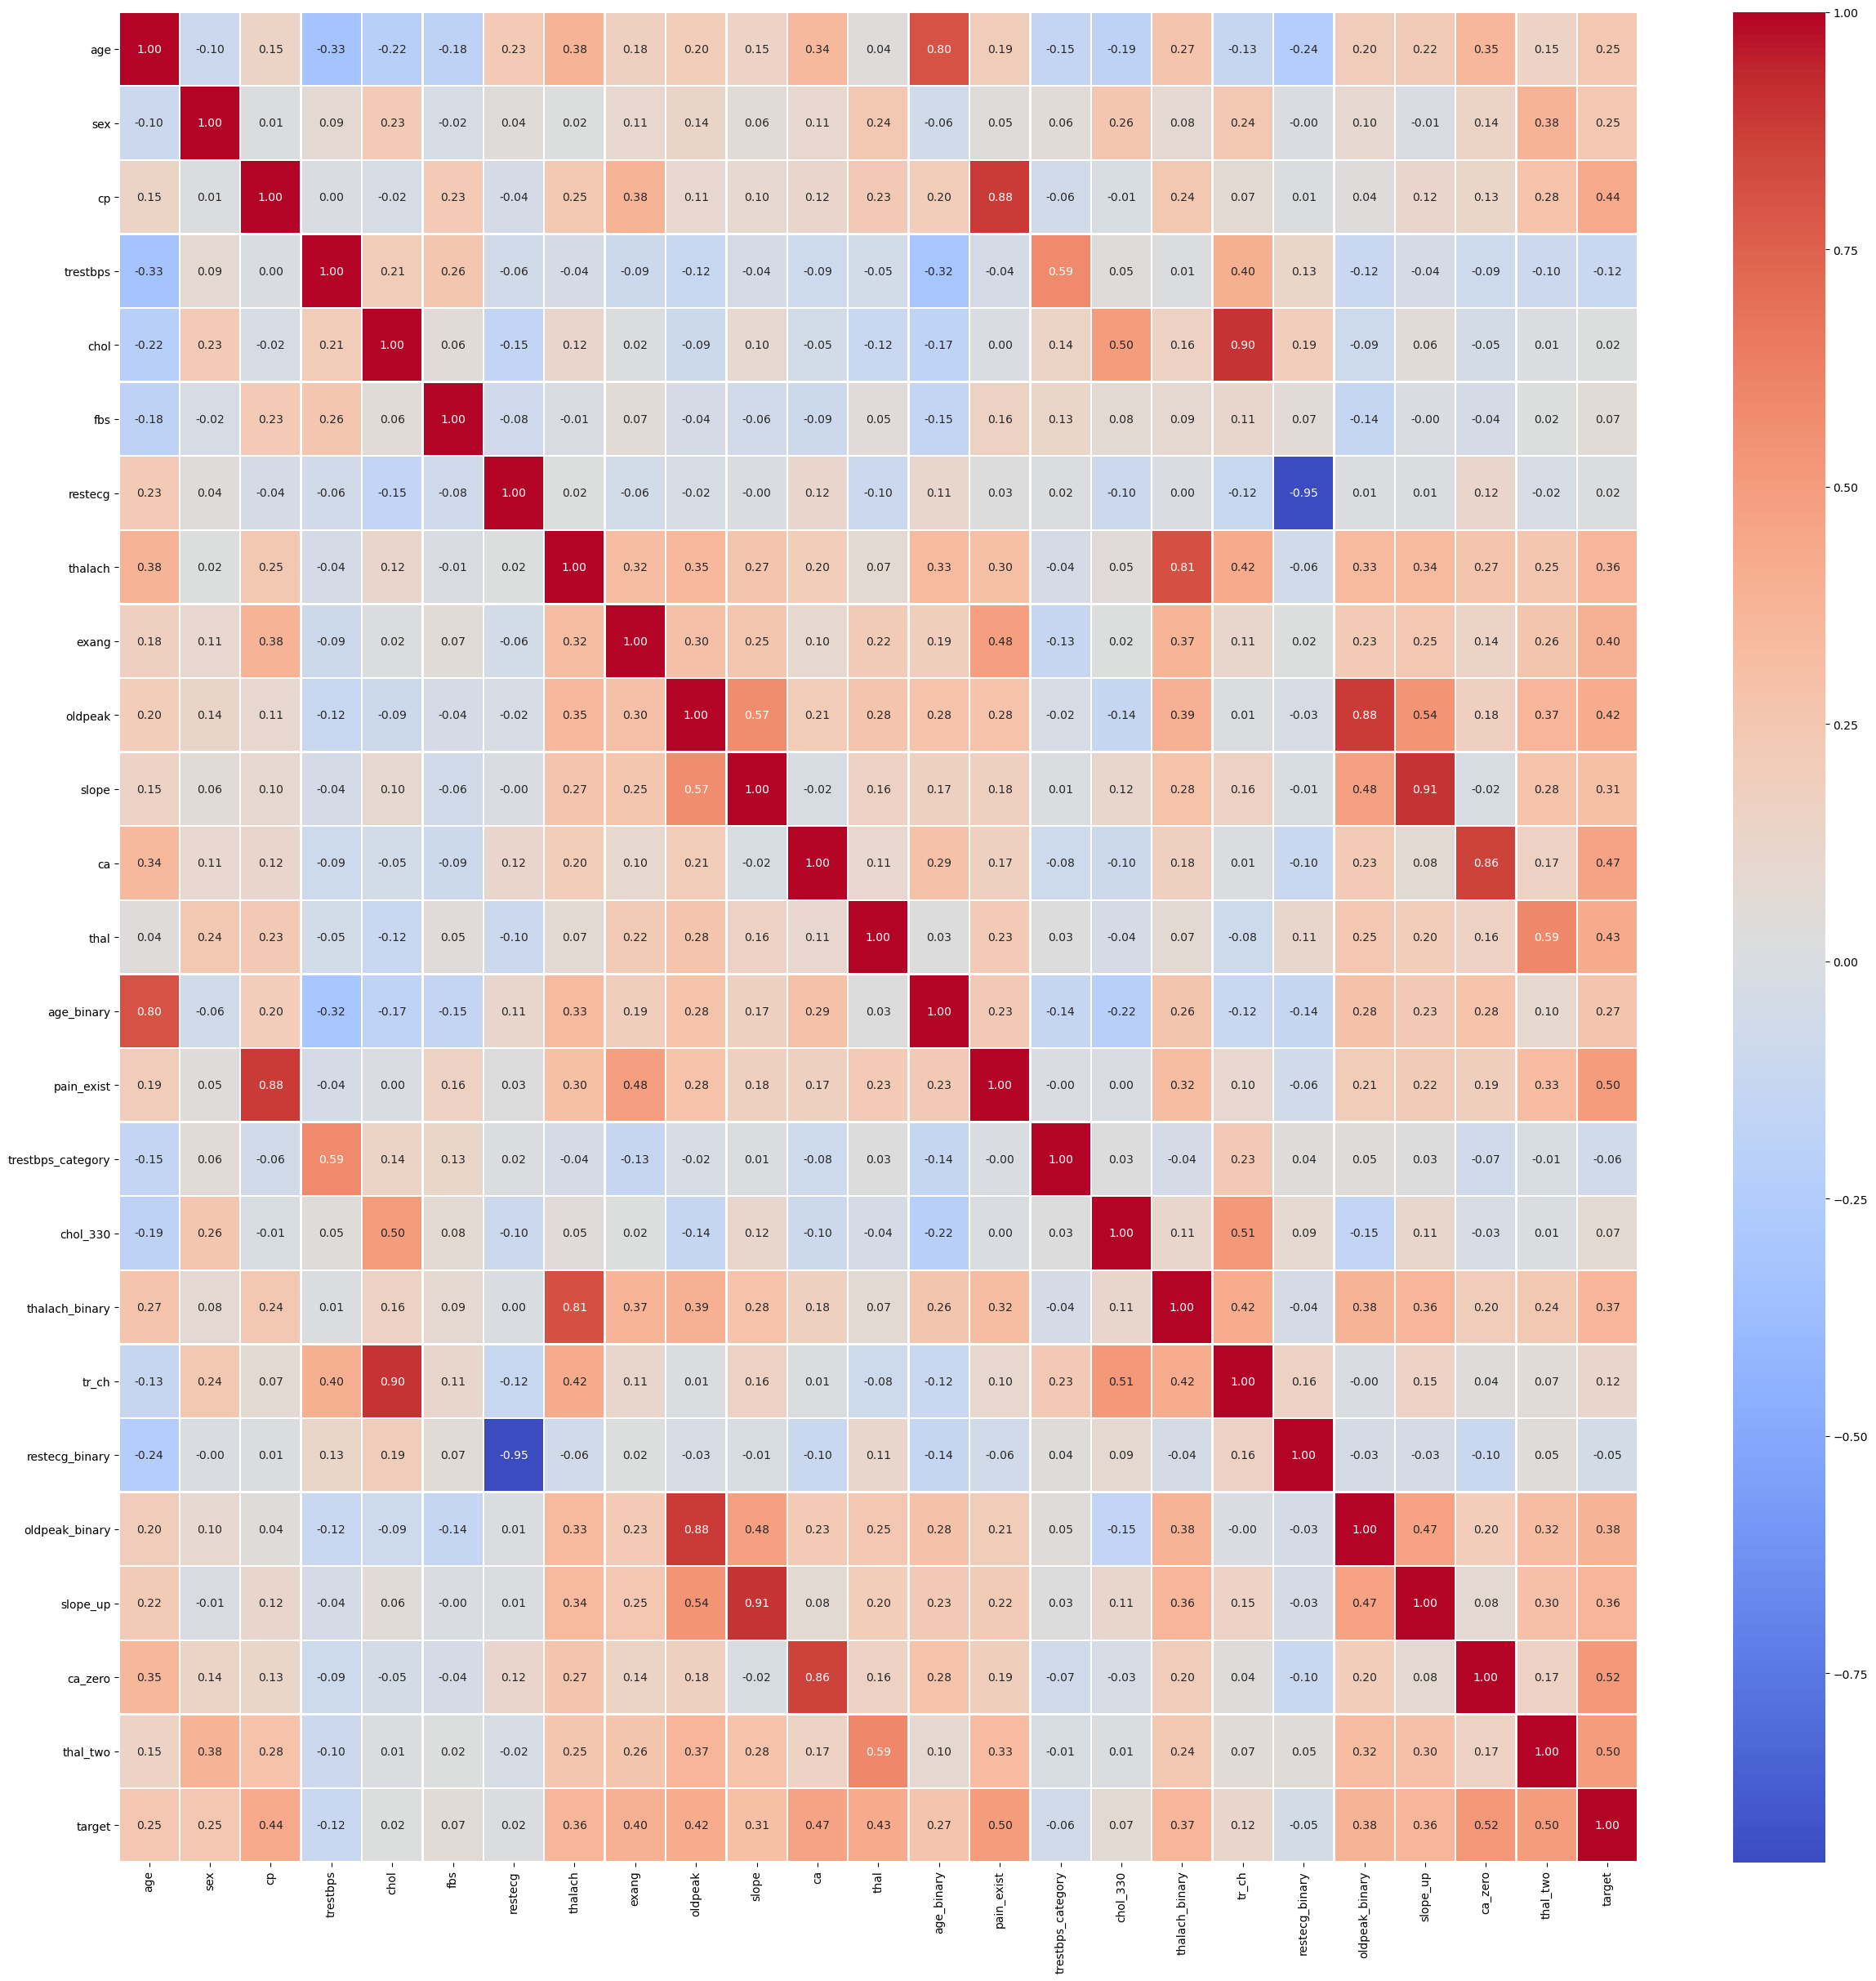

In [22]:
train_full = pd.concat([train_x, train['target']], axis = 1)

plt.figure(figsize = (30,30), dpi = 100)
sns.heatmap(data = train_full.corr(), annot = True, fmt = '.2f', linewidths = 1, cmap = 'coolwarm')
plt.show()

In [23]:
# scaling
scaler = MinMaxScaler()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test = scaler.transform(test)

# Dimension reduction

In [24]:
train_x.shape, test.shape

((151, 24), (152, 24))

In [25]:
pca = PCA(n_components = 0.95) # 0.95이 현재 최적
pca.fit(train_x)
train_x = pca.transform(train_x)
test = pca.transform(test)

In [26]:
train_x.shape, test.shape # 차원이 줄어든 것을 확인

((151, 13), (152, 13))

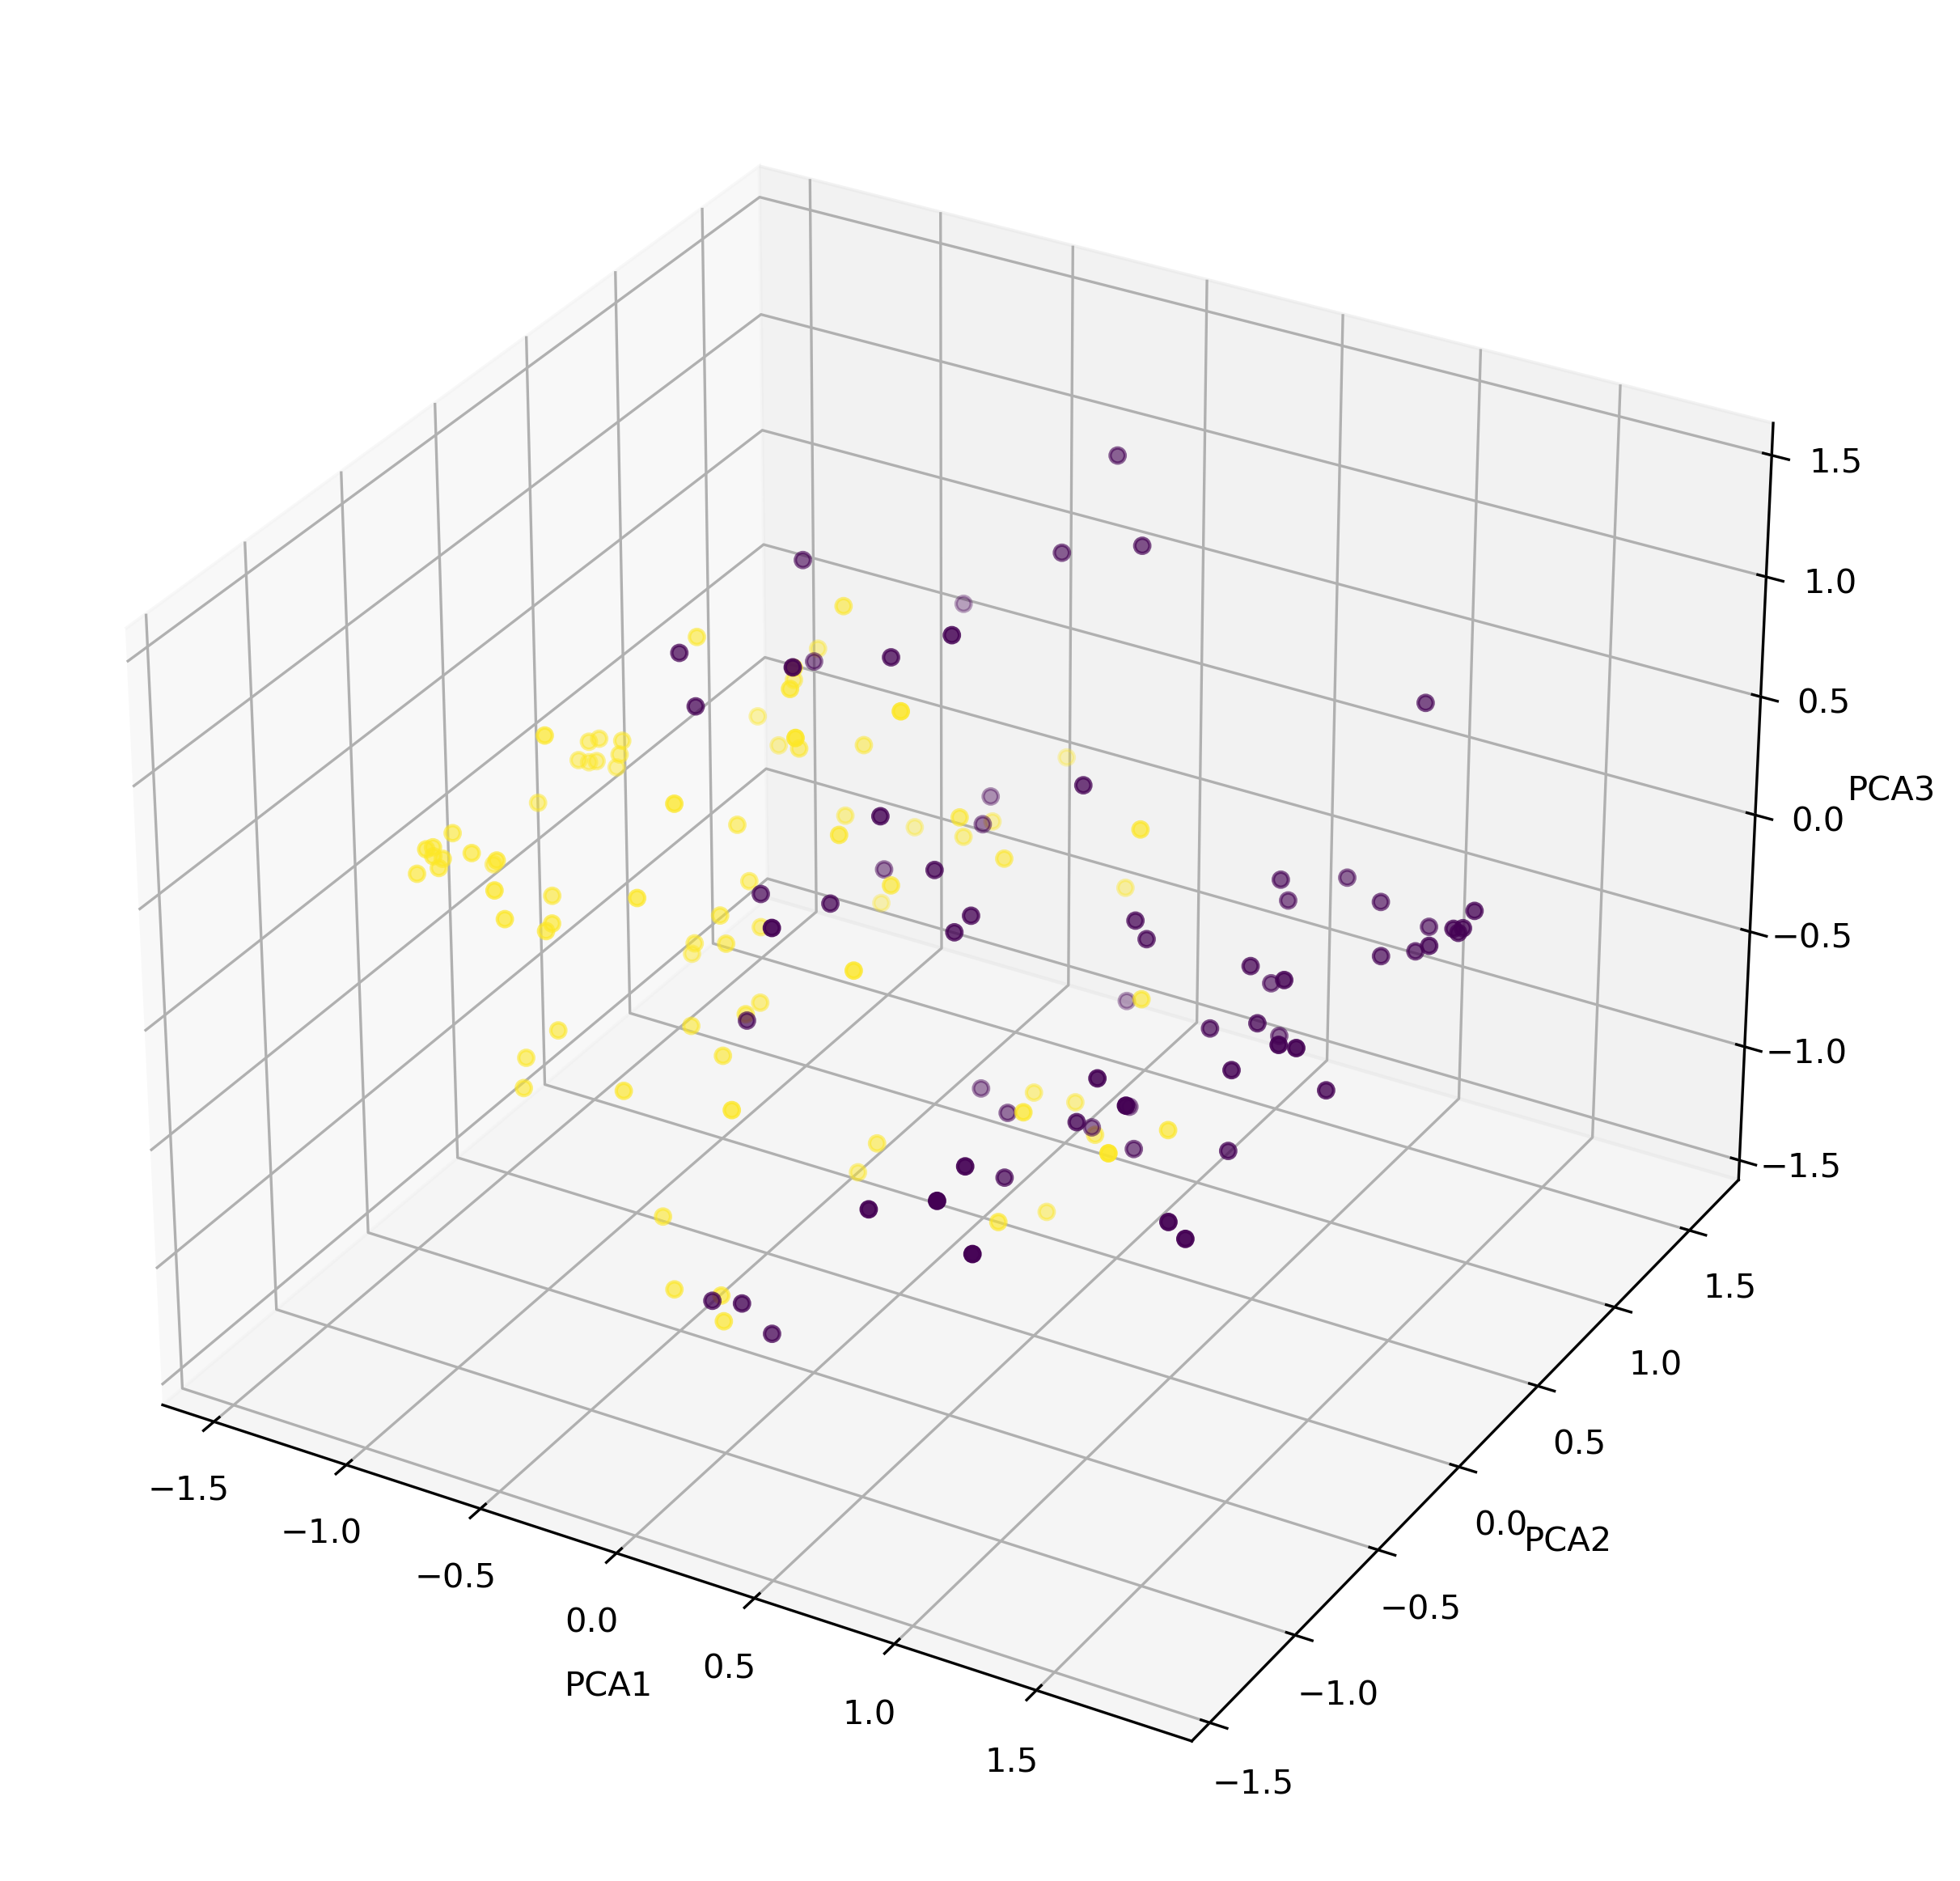

In [27]:
fig = plt.figure(figsize=(10,10), dpi = 300)
ax = fig.add_subplot(projection = '3d')
ax.scatter(train_x[:,0], train_x[:,1], train_x[:,2], c=train_y)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.show()

# Modeling

In [28]:
# KNeighborsClassifier GridSearchCV
params = {'n_neighbors' : list(range(1,31)),
          'weights' : ['uniform', 'distance'],
          'metric' : ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']
         }

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, scoring = 'f1', param_grid = params, cv=5, refit = True)
grid_knn.fit(train_x, train_y)

print('best parameters : ', grid_knn.best_params_)
print('best score : ', grid_knn.best_score_)

best parameters :  {'metric': 'chebyshev', 'n_neighbors': 9, 'weights': 'uniform'}
best score :  0.8769601467898681


In [29]:
knn = KNeighborsClassifier(metric = 'chebyshev', n_neighbors = 9, weights = 'uniform')
knn.fit(train_x, train_y)
pred = knn.predict(test)

In [30]:
submission['target'] = 0
submission['target'] = pred

In [31]:
submission

,id,target
0,1,0
1,2,1
2,3,1
3,4,0
4,5,1
...,...,...
147,148,0
148,149,0
149,150,0
150,151,1


In [32]:
submission.to_csv('my_submission.csv', index=False)